# Stop colab from Reconnecting (Not Used)

In [ ]:
import IPython
from google.colab import output

In [ ]:
display(IPython.display.Javascript('''
function ClickConnect(){
  btn = document.querySelector("colab-connect-button")
  if (btn != null){
    console.log("Click colab-connect-button");
    btn.click()
  }
  btn = document.getElementById('ok')
  if (btn != null){
    console.log("Click reconnect");
    btn.click()
  }
}

setInteraval(ClickConnect,60000)
'''))

<IPython.core.display.Javascript object>

# Install Tensorflow 1.x (Not used)

In [ ]:
!pip install tensorflow==1.13.1

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
%tensorflow_version 1.13.1

# Check GPU Tesla x

In [ ]:
!nvidia-smi

Tue May 11 11:38:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   1922MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9527799349999952
GPU (s):
0.040462568999998894
GPU speedup over CPU: 72x


# Install Tensorflow GPU

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 43kB/s 


# Speed up

In [ ]:
tf.compat.v1.enable_eager_execution()

# Mount From Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Dataset

In [ ]:
%cp -av "/content/drive/MyDrive/Datasets/D_ex" "/content/Dataset"

'/content/drive/MyDrive/Datasets/D_ex' -> '/content/Dataset/D_ex'


# Imports

In [ ]:
import os
import matplotlib.pyplot as plt
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model 
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorboard
import datetime
import tensorflow as tf

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
print(tf.__version__)

2.5.0


# Prepare the model

In [ ]:
img_width=224; img_height=224
batch_size = 256

TRAINING_DIR = '/content/Dataset/D_ex/train'
TESTING_DIR = '/content/Dataset/D_ex/test'
VALIDATION_DIR = '/content/Dataset/D_ex/validation' 

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# create a data generator
datagen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
train_generator = datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode=('rgb'),
                                                    target_size=(img_height, img_width)
                                                    )


validation_generator = datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              color_mode = ('rgb'),
                                                              target_size=(img_height, img_width)
                                                             )
test_it = datagen.flow_from_directory(TESTING_DIR , 
                                      class_mode='categorical', 
                                      batch_size=batch_size , 
                                      color_mode = ('rgb'),
                                      target_size=(img_height, img_width)
                                     )
#Found 20961 images belonging to 3 classes.
#Found 2465 images belonging to 3 classes.
#Found 2465 images belonging to 3 classes.

Found 20961 images belonging to 3 classes.
Found 2465 images belonging to 3 classes.
Found 2465 images belonging to 3 classes.


In [ ]:
print("Masked_Face:" , len(os.listdir('/content/Dataset/D_ex/train/Masked_Face')) + len(os.listdir('/content/Dataset/D_ex/validation/Masked_Face')))
print("with_mask: " ,  len(os.listdir('/content/Dataset/D_ex/train/with_mask')) + len(os.listdir('/content/Dataset/D_ex/validation/with_mask')) )
print("without_mask:" , len(os.listdir('/content/Dataset/D_ex/train/without_mask')) + len(os.listdir('/content/Dataset/D_ex/validation/without_mask') ))

Masked_Face: 742
with_mask:  11420
without_mask: 11264


In [ ]:
 # Load the TensorBoard notebook extension
%load_ext tensorboard
#callbacks = EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='auto')
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
best_model_file = '/content/drive/MyDrive/Best_Weights/weights.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)
reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

# VGG16 Model as base Model + Head Model
# Note: The one we worked with

In [ ]:
#wp = 'best_weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base = VGG16(include_top=False, weights="imagenet",
                   input_tensor=None, input_shape=(img_height, img_width, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(3, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [ ]:
vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

     |████████████████████████████████| 798kB 5.1MB/s 


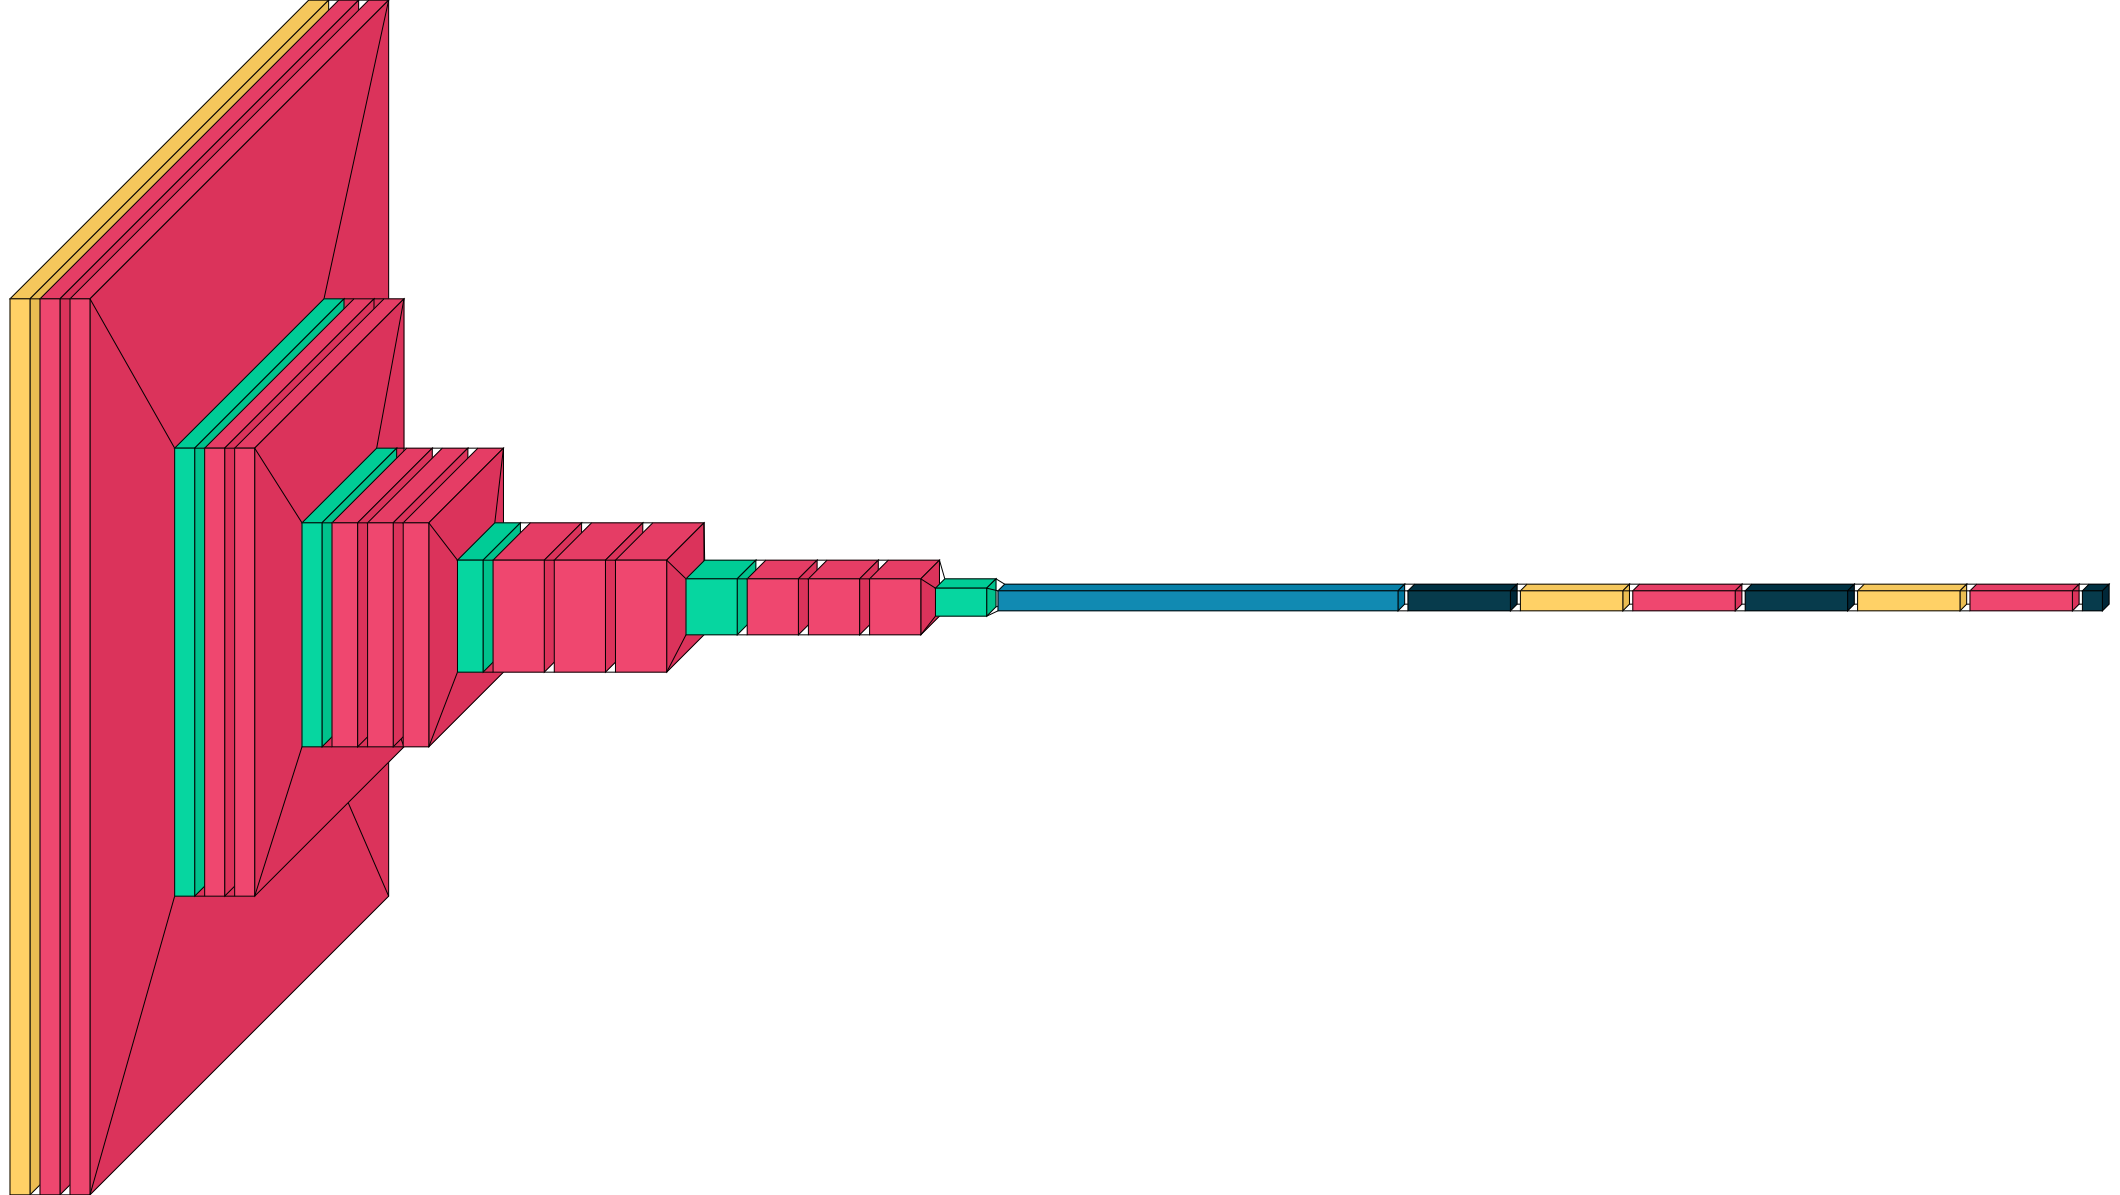

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(vgg16_model, to_file='output.png')

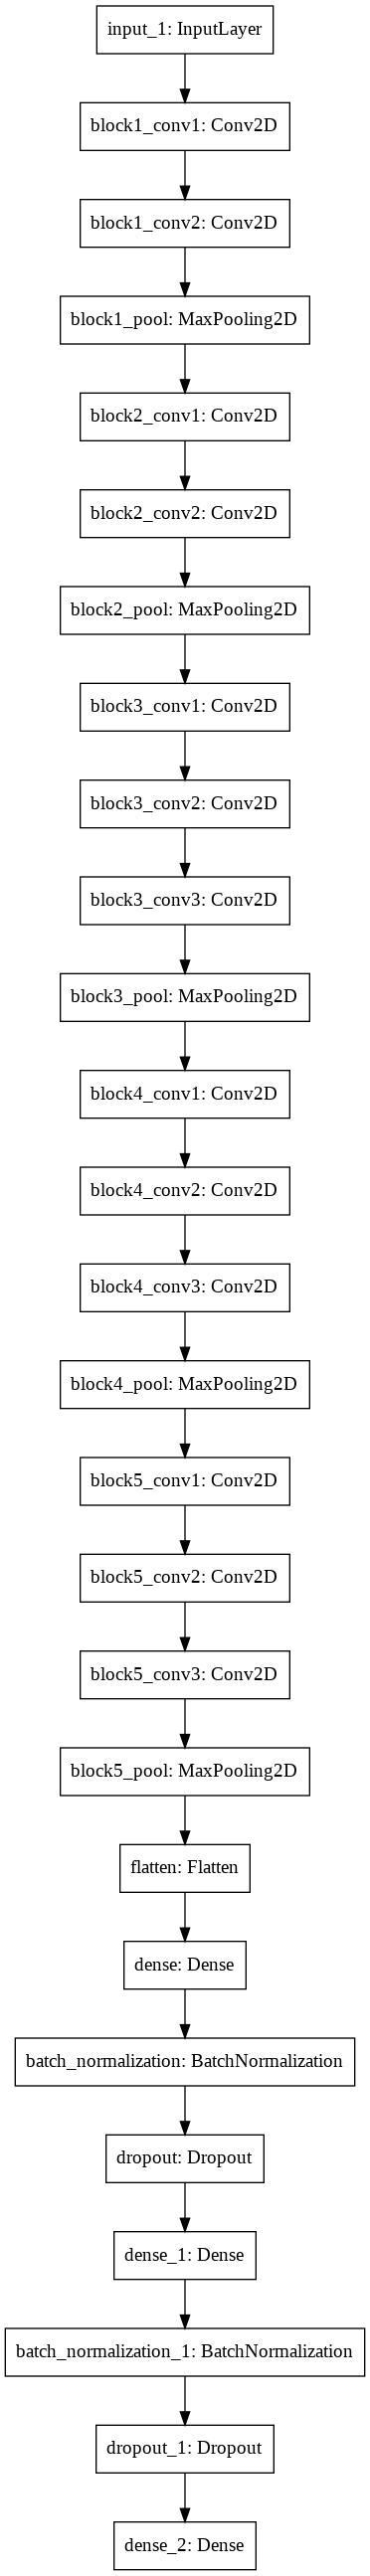

In [ ]:
plot_model(vgg16_model, to_file='Masked_Face_Model_Base_VGG16.png')

# MobileNetv2 Model as Base Model + The Head (Not Used) (First Version)

In [ ]:
base_Model = MobileNetV2(input_tensor = tf.keras.layers.Input(shape = (224,224,3)),include_top = False, weights = 'imagenet')

In [ ]:
base_Model.summary()

In [ ]:
plot_model(base_Model, to_file='vgg16.png')

In [ ]:
base_Model.output          # tensor object to be used later in model making

headModel = base_Model.output              # headModel input is Basemodel's output
headModel = tf.keras.layers.AveragePooling2D(pool_size = (7,7))(headModel)
headModel = tf.keras.layers.Flatten()(headModel)
headModel = tf.keras.layers.Dense(128, activation = 'relu')(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(3, activation = 'softmax')(headModel)

In [ ]:
model = tf.keras.models.Model(inputs = base_Model.input, outputs = headModel)

"""## Freezing Base Model's layers to prevent them from training
Model's Trainable parameter as False.
"""

base_Model.layers

for layers in base_Model.layers:
  base_Model.trainable = False

In [ ]:
def make_model(batch_size=None):
    
    vgg16_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return vgg16_model


training_model = make_model(batch_size=128)

In [ ]:
vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

# Trying to deal with the model in TPU Mode (Failed -Not Used-)

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow.compat.v1 as t
t.disable_v2_behavior()

In [ ]:
#import os
#import tensorflow as tf
# This address identifies the TPU we'll use when configuring TensorFlow.


# tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver) 



# resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)



TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    training_model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


In [ ]:
import numpy as np

In [ ]:
history = tpu_model.fit(np.array(train_generator),
                        epochs=30,
                        batch_size=128 * 8,
                        validation_data=np.array(validation_generator),
                        callbacks = [callbacks, best_model , tensorboard_callback , reduce_lr]
                                           
                        )


In [ ]:
tpu_model.save_weights('./tpu_model.h5', overwrite=True)
tpu_model.evaluate(x_test, y_test, batch_size=128 * 8)

# Start Compile and Training

In [ ]:
vgg16_model.compile(optimizer='Adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = vgg16_model.fit_generator(train_generator,
                                    epochs=30,
                                    steps_per_epoch= 20961 // batch_size,
                                    validation_data=validation_generator,
                                    validation_steps=2465 // batch_size,
                                    callbacks = [callbacks, best_model , tensorboard_callback , reduce_lr]
                                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
43/81 [==============>...............] - ETA: 53:57 - loss: 0.4790 - accuracy: 0.8652

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


81/81 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.9012  

# Training

In [ ]:
init_lr = 1e-4
epochs = 30
opt = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(optimizer=opt, loss = 'categorical_crossentropy',metrics = ['accuracy'])

"""## Fitting the model"""

'## Fitting the model'

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch= 20961 // batch_size,
                    validation_data=validation_generator,
                    validation_steps=2465 // batch_size,
                    callbacks = [callbacks, best_model , tensorboard_callback , reduce_lr]
                    )

Epoch 1/30
 1/81 [..............................] - ETA: 2:47:17 - loss: 2.4321 - accuracy: 0.1250

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 3/81 [>.............................] - ETA: 2:40:46 - loss: 2.2417 - accuracy: 0.1543

## Open Tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
target_dir = 'Multi_Predict_vgg16_best_weights_256'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg16_model.save('Multi_Predict_vgg16_best_weights_256\vgg16_model_256.h5')
vgg16_model.save('Multi_Predict_vgg16_best_weights_256\vgg16_model_256.model')
vgg16_model.save_weights('Multi_Predict_vgg16_best_weights_256\vgg16_weights_256.h5')

INFO:tensorflow:Assets written to: Multi_Predict_vgg16_best_weights_256gg16_model_256.model/assets


# Testing

In [ ]:
vgg16_model.save('vgg16_model_256.model')

INFO:tensorflow:Assets written to: vgg16_model_256.model/assets


In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

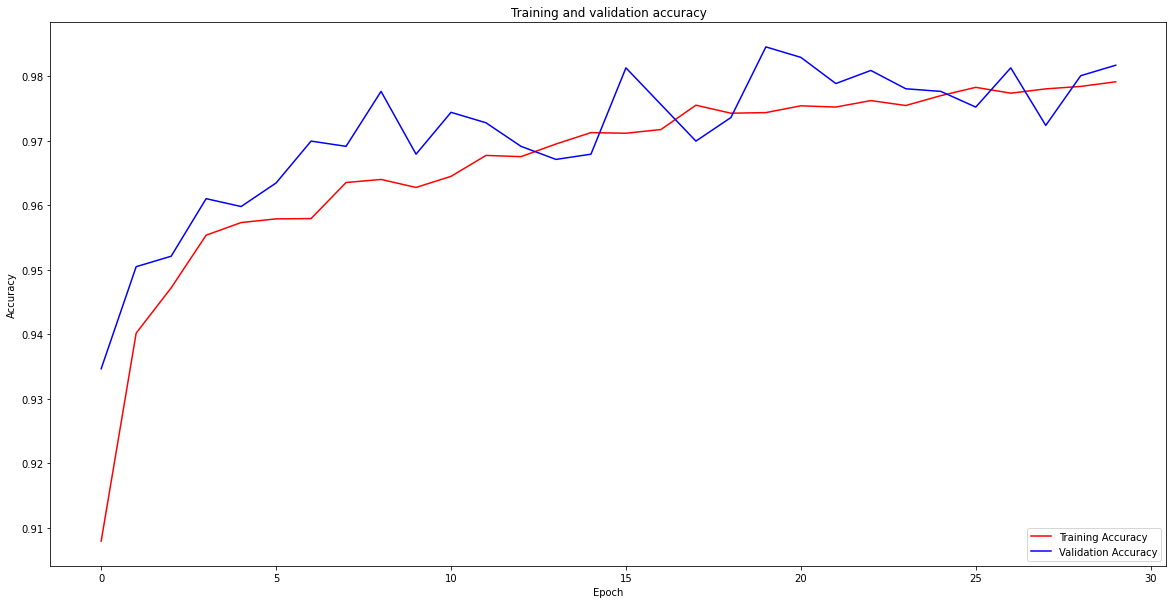

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Multi_Predict_vgg16_best_weights_256\Accuracy_curve_vgg16_drop_batch_256.jpg')

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Multi_Predict_vgg16_best_weights_256\Accuracy_curve_vgg16_drop_batch_256.jpg')

In [ ]:
# evaluate model
loss = vgg16_model.evaluate_generator(test_it, steps=2465 // batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
loss

[18298.837890625, 0.8859577775001526]

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding

def make_model(batch_size=None):
    source = Input(shape=(maxlen,), batch_size=batch_size,
                   dtype=tf.int32, name='Input')
    embedding = Embedding(input_dim=max_features,
                          output_dim=128, name='Embedding')(source)
    lstm = LSTM(32, name='LSTM')(embedding)
    predicted_var = Dense(1, activation='sigmoid', name='Output')(lstm)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_var])
    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['acc'])
    return model


training_model = make_model(batch_size=128)


In [ ]:
!sudo apt-get install nano

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  spell
The following NEW packages will be installed:
  nano
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 231 kB of archives.
After this operation, 778 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 nano amd64 2.9.3-2 [231 kB]
Fetched 231 kB in 1s (324 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
!nano ~/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator.py

>Received SIGHUP or SIGTERM


# Confusion Matrix

In [ ]:
import numpy as np
from tensorflow import keras
from keras.preprocessing import image
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools  

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Models/Mask/Mask_model.h5')

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
!rm -rf "/content/Dataset/D_ex/test/.ipynb_checkpoints"

In [ ]:
type(validation_generator)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
#Print the Target names

target_names = []
for key in validation_generator.class_indices:
    target_names.append(key)

print(target_names)

['Masked_Face', 'with_mask', 'without_mask']


In [ ]:
#Confution Matrix 

Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred , normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
#plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
#Print Classification Report

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Plot Model (Not Used)

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 798kB 15.2MB/s 


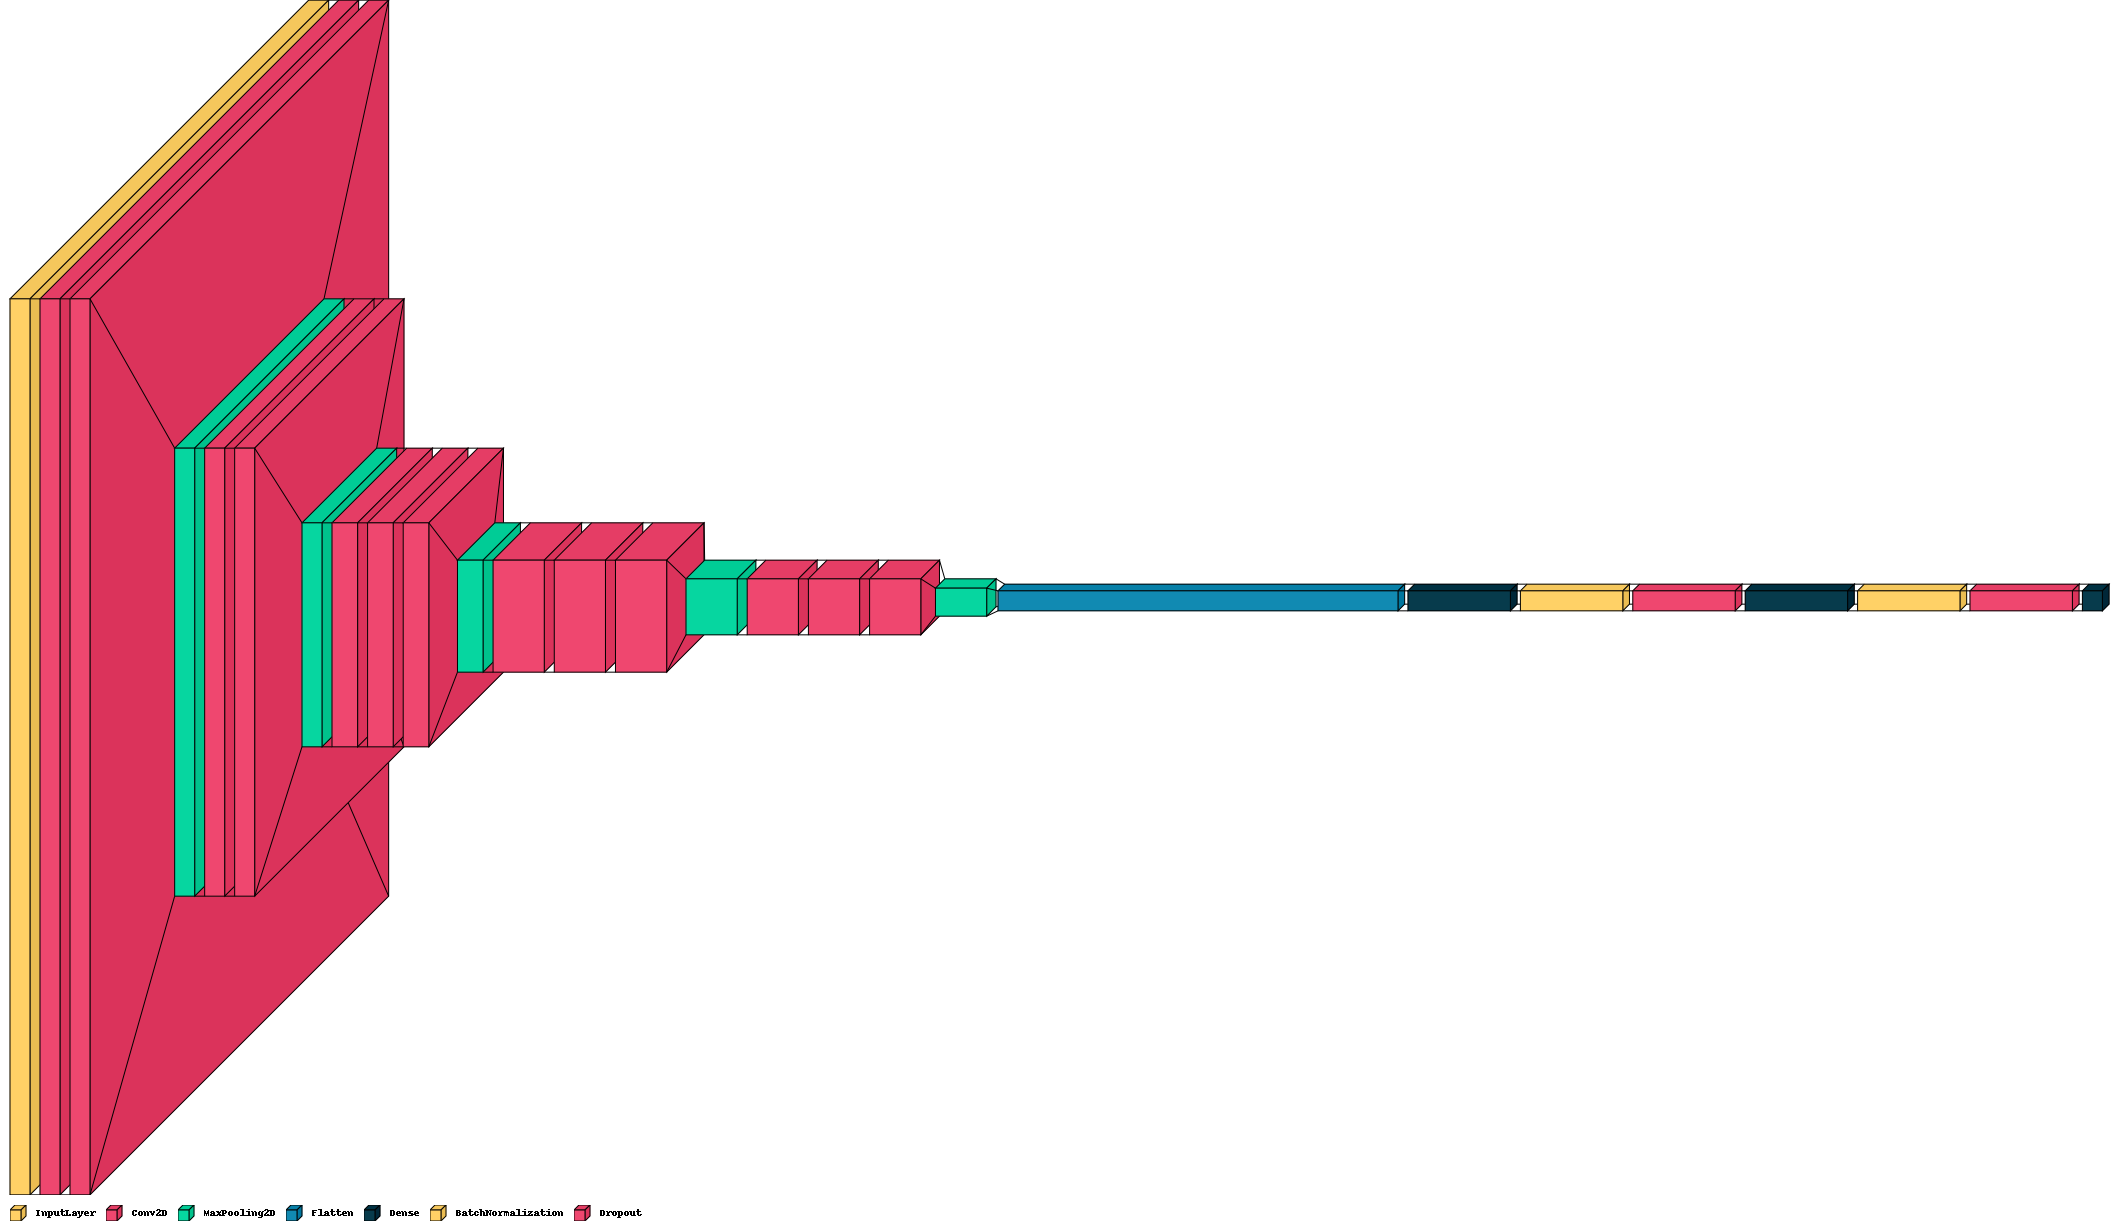

In [ ]:
import visualkeras
visualkeras.layered_view(vgg16_model, legend=True ,to_file='output.png')

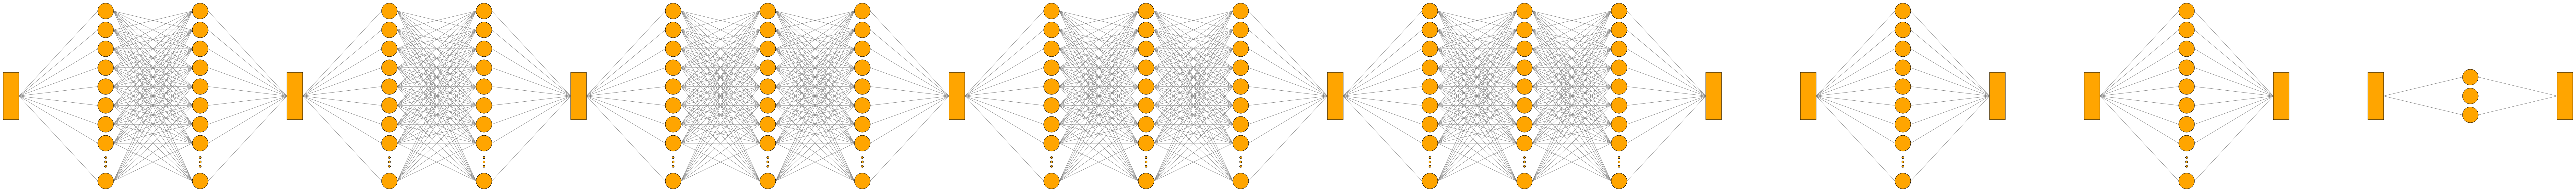

In [ ]:
visualkeras.graph_view(model)

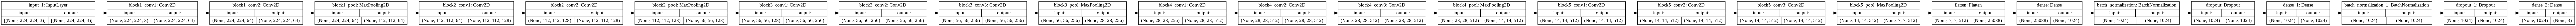

In [ ]:
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50
import numpy as np

#model = ResNet50(weights='imagenet')
plot_model(model,show_shapes=True,
    to_file='model.png' , rankdir='LR')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


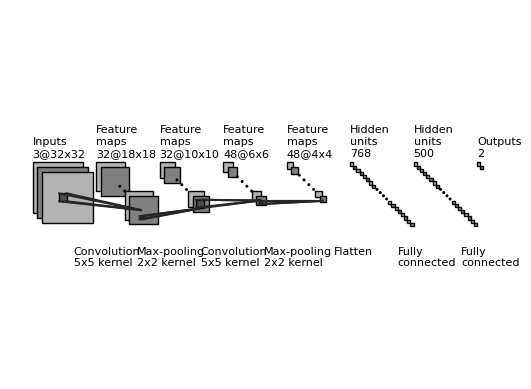

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

NumDots = 4
NumConvMax = 8
NumFcMax = 20
White = 1.
Light = 0.7
Medium = 0.5
Dark = 0.3
Darker = 0.15
Black = 0.


def add_layer(patches, colors, size=(24, 24), num=5,
              top_left=[0, 0],
              loc_diff=[3, -3],
              ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    for ind in range(num):
        patches.append(Rectangle(loc_start + ind * loc_diff, size[1], size[0]))
        if ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_layer_with_omission(patches, colors, size=(24, 24),
                            num=5, num_max=8,
                            num_dots=4,
                            top_left=[0, 0],
                            loc_diff=[3, -3],
                            ):
    # add a rectangle
    top_left = np.array(top_left)
    loc_diff = np.array(loc_diff)
    loc_start = top_left - np.array([0, size[0]])
    this_num = min(num, num_max)
    start_omit = (this_num - num_dots) // 2
    end_omit = this_num - start_omit
    start_omit -= 1
    for ind in range(this_num):
        if (num > num_max) and (start_omit < ind < end_omit):
            omit = True
        else:
            omit = False

        if omit:
            patches.append(
                Circle(loc_start + ind * loc_diff + np.array(size) / 2, 0.5))
        else:
            patches.append(Rectangle(loc_start + ind * loc_diff,
                                     size[1], size[0]))

        if omit:
            colors.append(Black)
        elif ind % 2:
            colors.append(Medium)
        else:
            colors.append(Light)


def add_mapping(patches, colors, start_ratio, end_ratio, patch_size, ind_bgn,
                top_left_list, loc_diff_list, num_show_list, size_list):

    start_loc = top_left_list[ind_bgn] \
        + (num_show_list[ind_bgn] - 1) * np.array(loc_diff_list[ind_bgn]) \
        + np.array([start_ratio[0] * (size_list[ind_bgn][1] - patch_size[1]),
                    - start_ratio[1] * (size_list[ind_bgn][0] - patch_size[0])]
                   )




    end_loc = top_left_list[ind_bgn + 1] \
        + (num_show_list[ind_bgn + 1] - 1) * np.array(
            loc_diff_list[ind_bgn + 1]) \
        + np.array([end_ratio[0] * size_list[ind_bgn + 1][1],
                    - end_ratio[1] * size_list[ind_bgn + 1][0]])


    patches.append(Rectangle(start_loc, patch_size[1], -patch_size[0]))
    colors.append(Dark)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)
    patches.append(Line2D([start_loc[0] + patch_size[1], end_loc[0]],
                          [start_loc[1] - patch_size[0], end_loc[1]]))
    colors.append(Darker)



def label(xy, text, xy_off=[0, 4]):
    plt.text(xy[0] + xy_off[0], xy[1] + xy_off[1], text,
             family='sans-serif', size=8)


if __name__ == '__main__':

    fc_unit_size = 2
    layer_width = 40
    flag_omit = True

    patches = []
    colors = []

    fig, ax = plt.subplots()


    ############################
    # conv layers
    size_list = [(32, 32), (18, 18), (10, 10), (6, 6), (4, 4)]
    num_list = [3, 32, 32, 48, 48]
    x_diff_list = [0, layer_width, layer_width, layer_width, layer_width]
    text_list = ['Inputs'] + ['Feature\nmaps'] * (len(size_list) - 1)
    loc_diff_list = [[3, -3]] * len(size_list)

    num_show_list = list(map(min, num_list, [NumConvMax] * len(num_list)))
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]

    for ind in range(len(size_list)-1,-1,-1):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumConvMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind], loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}@{}x{}'.format(
            num_list[ind], size_list[ind][0], size_list[ind][1]))

    ############################
    # in between layers
    start_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    end_ratio_list = [[0.4, 0.5], [0.4, 0.8], [0.4, 0.5], [0.4, 0.8]]
    patch_size_list = [(5, 5), (2, 2), (5, 5), (2, 2)]
    ind_bgn_list = range(len(patch_size_list))
    text_list = ['Convolution', 'Max-pooling', 'Convolution', 'Max-pooling']

    for ind in range(len(patch_size_list)):
        add_mapping(
            patches, colors, start_ratio_list[ind], end_ratio_list[ind],
            patch_size_list[ind], ind,
            top_left_list, loc_diff_list, num_show_list, size_list)
        label(top_left_list[ind], text_list[ind] + '\n{}x{} kernel'.format(
            patch_size_list[ind][0], patch_size_list[ind][1]), xy_off=[26, -65]
        )


    ############################
    # fully connected layers
    size_list = [(fc_unit_size, fc_unit_size)] * 3
    num_list = [768, 500, 2]
    num_show_list = list(map(min, num_list, [NumFcMax] * len(num_list)))
    x_diff_list = [sum(x_diff_list) + layer_width, layer_width, layer_width]
    top_left_list = np.c_[np.cumsum(x_diff_list), np.zeros(len(x_diff_list))]
    loc_diff_list = [[fc_unit_size, -fc_unit_size]] * len(top_left_list)
    text_list = ['Hidden\nunits'] * (len(size_list) - 1) + ['Outputs']

    for ind in range(len(size_list)):
        if flag_omit:
            add_layer_with_omission(patches, colors, size=size_list[ind],
                                    num=num_list[ind],
                                    num_max=NumFcMax,
                                    num_dots=NumDots,
                                    top_left=top_left_list[ind],
                                    loc_diff=loc_diff_list[ind])
        else:
            add_layer(patches, colors, size=size_list[ind],
                      num=num_show_list[ind],
                      top_left=top_left_list[ind],
                      loc_diff=loc_diff_list[ind])
        label(top_left_list[ind], text_list[ind] + '\n{}'.format(
            num_list[ind]))

    text_list = ['Flatten\n', 'Fully\nconnected', 'Fully\nconnected']

    for ind in range(len(size_list)):
        label(top_left_list[ind], text_list[ind], xy_off=[-10, -65])

    ############################
    for patch, color in zip(patches, colors):
        patch.set_color(color * np.ones(3))
        if isinstance(patch, Line2D):
            ax.add_line(patch)
        else:
            patch.set_edgecolor(Black * np.ones(3))
            ax.add_patch(patch)

    plt.tight_layout()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    fig.set_size_inches(8, 2.5)

    fig_dir = './'
    fig_ext = '.png'
    fig.savefig(os.path.join(fig_dir, 'convnet_fig' + fig_ext),
                bbox_inches='tight', pad_inches=0)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
!pip install plot-model
!pip install pydot
!pip install pydot_ng
!pip install graphviz

In [ ]:
from plot_model import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

In [ ]:
!pip uninstall tf-agents

In [ ]:
!pip install tf-agents-nightly

     |████████████████████████████████| 1.2MB 11.8MB/s 
     |████████████████████████████████| 5.4MB 33.3MB/s 


In [ ]:
from tf_agents.agents.dqn import dqn_agent